In [ ]:
#default_exp sio

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  


# Structure IO

> This includes generating POSCAR form [Materials Project](https://materialsproject.org/). You need their API key to run functions in this module where required.

**Note** : To use materials project data frequently, you may need to save their api key into file. Run function below and it saves key to a file and every function will autoload it.

In [ ]:
#export
import sys, os, re
import json
import numpy as np
from pathlib import Path
import requests as req
from collections import namedtuple
from itertools import product, permutations
from functools import lru_cache

from scipy.spatial import ConvexHull, Voronoi, KDTree
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.colors as mplc #For viewpoint
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Inside packages import to work both with package and jupyter notebook.
try:
    from pivotpy import vr_parser as vp, serializer
    from pivotpy import splots as sp
except:
    import pivotpy.vr_parser as vp
    import pivotpy.splots as sp
    import pivotpy.serializer as serializer

In [ ]:
#hide_input
# To run notebook smoothly, not for module export
from pivotpy.sio import get_bz, splot_bz

In [ ]:
#export
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    """Draw 3D fancy arrow."""
    def __init__(self, x, y, z, u, v, w, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = [x,x+u], [y,y+v], [z,z+w]

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)

    def on(self,ax):
        ax.add_artist(self)

def fancy_quiver3d(X,Y,Z,U,V,W,ax=None,C = 'r',L = 0.7,mutation_scale=10,**kwargs):
    """Plots 3D arrows on a given ax. See [FancyArrowPatch](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.patches.FancyArrowPatch.html).
    - **Parameters**
        - X, Y, Z : 1D arrays of coordinates of arrows' tail point.
        - U, V, W : 1D arrays of dx,dy,dz of arrows.
        - ax: 3D axes, if not given, auto created.
        - C : 1D colors array mapping for arrows. Could be one color.
        - L : 1D linwidths array mapping for arrows. Could be one linewidth.
        - mutation_scale: Arrow head width/size scale. Default is 10.
        - kwargs: FancyArrowPatch's keyword arguments excluding positions,color, lw and mutation_scale, shrinkA, shrinkB which are already used. An important keyword argument is `arrowstyle` which could be '->','-|>', their inverted forms and many more. See on matplotlib.
    """
    if not ax:
        ax = sp.get_axes(figsize=(3.4,3.4),axes_3d=True) # Same aspect ratio.
    if not isinstance(C,(list,np.ndarray)):
        C = [[*mplc.to_rgb(C)] for x in X]
    C = np.array(C) # Safe for list

    if not isinstance(L,(list,np.ndarray)):
        L = [L for x in X]
    args_dict = dict(mutation_scale=mutation_scale,shrinkA=0, shrinkB=0)
    for x,y,z,u,v,w,c,l in zip(X,Y,Z,U,V,W,C,L):
        Arrow3D(x, y, z, u, v, w, color=c,lw=l,**args_dict,**kwargs).on(ax)

    return ax

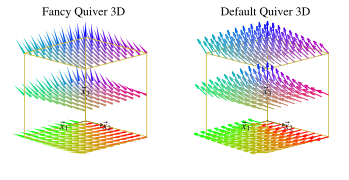

In [ ]:
def field(x,y,z):
    u, v, w = y, -x , z
    norm = 5*(u*u + v*v + w*w)**(1/2)
    if norm == 0:
        return (x,y,z,0.01,0.01,0.01)
    return (x,y,z, u/norm, v/norm, w/norm)

X,Y,Z = np.mgrid[0:1:10j,0:1:10j,0:1:3j]
vs = np.concatenate([X.ravel(),Y.ravel(),Z.ravel()]).reshape((3,-1)).T

ef = np.array([field(*v) for v in vs]).T

C = np.abs(ef[3:,:].T)
C = C/np.max(C)

ax1, ax2 = sp.get_axes(ncols=2,figsize=(6,3),axes_3d=[0,1])
bz = get_bz([[1,0,0],[0,1,0],[0,0,1]],primitive=True)
splot_bz(bz,ax=ax1,vname='x',fill=False,color=(0.8,0.7,0.2,0.7))
splot_bz(bz,ax=ax2,vname='x',fill=False,color=(0.8,0.7,0.2,0.7))

fancy_quiver3d(*ef,C = C,ax=ax1,L=0.01,mutation_scale=7,capstyle='butt',arrowstyle='wedge').set_box_aspect((1,1,1))
ax1.set_axis_off()
ax1.set_title('Fancy Quiver 3D')

# Repeat for each body line and two head lines
C = np.concatenate([C,np.repeat(C, 2, axis=0)])
q = ax2.quiver(*ef,lw=1,colors=C)
ax2.set_title('Default Quiver 3D')
ax2.set_box_aspect((1,1,1))
ax2.set_axis_off()

In [ ]:
#export
def write_poscar(poscar,sd_list=None,outfile=None,overwrite=False):
    """Writes poscar data object to a file or returns string
    - **Parameters**
        - poscar   : Output of `export_poscar`,`join_poscars` etc.
        - sd_list  : A list ['T T T','F F F',...] strings to turn on selective dynamics at required sites. len(sd_list)==len(sites) should hold.
        - outfile  : str,file path to write on.
        - overwrite: bool, if file already exists, overwrite=True changes it.
    """
    out_str = poscar.SYSTEM + "  # Created by Pivotpy"
    scale = np.linalg.norm(poscar.basis[0])
    out_str += "\n  {:<20.14f}\n".format(scale)
    out_str += '\n'.join(["{:>22.16f}{:>22.16f}{:>22.16f}".format(*a) for a in poscar.basis/scale])
    uelems = poscar.unique.to_dict()
    out_str += "\n  " + '\t'.join(uelems.keys())
    out_str += "\n  " + '\t'.join([str(len(v)) for v in uelems.values()])
    if sd_list:
        out_str += "\nSelective Dynamics"
    out_str += "\nDirect\n"
    pos_list = ["{:>21.16f}{:>21.16f}{:>21.16f}".format(*a) for a in poscar.positions]
    if sd_list:
        if len(pos_list) != len(sd_list):
            raise ValueError("len(sd_list) != len(sites).")
        pos_list = [f"{p}   {s}" for p,s in zip(pos_list,sd_list)]
    out_str += '\n'.join(pos_list)
    if outfile:
        if not os.path.isfile(outfile):
            with open(outfile,'w') as f:
                f.write(out_str)
            
        elif overwrite and os.path.isfile(outfile):
            with open(outfile,'w') as f:
                f.write(out_str)
        else:
            raise FileExistsError(f"{outfile!r} exists, can not overwrite, \nuse overwrite=True if you want to chnage.")
    else:
        print(out_str)

def export_poscar(path=None,text_plain=None):
    """Export POSCAR file to python objects.
    - **Parameters**
        - path: Path/to/POSCAR file. Auto picks in CWD.
        - text_plain: POSCAR content as string, This takes precedence to path.
    """
    if text_plain and isinstance(text_plain,str):
        path = text_plain.splitlines() # This acts as slice for islice2array.
    elif not path:
        path = './POSCAR'
        if not os.path.isfile(path):
            raise FileNotFoundError
        
    SYSTEM = vp.islice2array(path,start=0,nlines=1,raw=True,exclude=None).split()[0]
    scale = vp.islice2array(path,start=1,nlines=1,exclude=None).squeeze()
    basis = scale*vp.islice2array(path,start=2,nlines=3,exclude=None).reshape((-1,3))
    volume = np.linalg.det(basis)
    rec_basis = np.linalg.inv(basis).T # general formula
    out_dict = {'SYSTEM':SYSTEM,'volume':volume,'basis':basis,'rec_basis':rec_basis}

    elems = vp.islice2array(path,raw=True,start=5,nlines=1,exclude=None).split()
    ions = vp.islice2array(path,start=6,nlines=1,exclude=None)
    N = np.sum(ions).astype(int)
    inds = np.cumsum([0,*ions]).astype(int)
    # Two lines are excluded in below command before start. so start = 7-2
    positions = vp.islice2array(path,start=5,exclude="^\s+[a-zA-Z]|^[a-zA-Z]",cols=[0,1,2]).reshape((-1,3))[:N]


    unique_d = {}
    for i,e in enumerate(elems):
        unique_d.update({e:range(inds[i],inds[i+1])})

    elem_labels = []
    for i, name in enumerate(elems):
        for ind in range(inds[i],inds[i+1]):
            elem_labels.append(f"{name} {str(ind - inds[i] + 1)}")
    out_dict.update({'positions':positions,'labels':elem_labels,'unique':unique_d})
    return vp._add_text_attr2poscar(serializer.PoscarData(out_dict))
    

In [ ]:
#export
def _save_mp_API(api_key):
    """
    - Save materials project api key for autoload in functions.
    """
    home = str(Path.home())
    file = os.path.join(home,'.pivotpyrc')
    lines = []
    if os.path.isfile(file):
        with open(file,'r') as fr:
            lines = fr.readlines()
            lines = [line for line in lines if 'MP_API_KEY' not in line]
        
    with open(file,'w') as fw:
        fw.write("MP_API_KEY = {}".format(api_key))
        for line in lines:
            fw.write(line)

In [ ]:
#export
def _load_mp_data(formula,api_key=None,mp_id=None,max_sites = None, min_sites = None):
    """
    - Returns fetched data using request api of python form materials project website.
    - **Parameters**
        - formula  : Material formula such as 'NaCl'.
        - api_key  : API key for your account from material project site. Auto picks if you already used `_save_mp_API` function.
        - mp_id     : Optional, you can specify material ID to filter results.
        - max_sites : Maximum number of sites. If None, sets `min_sites + 1`, if `min_sites = None`, gets all data.
        - min_sites : Minimum number of sites. If None, sets `max_sites + 1`, if `max_sites = None`, gets all data.
    """
    if api_key is None:
        try:
            home = str(Path.home())
            file = os.path.join(home,'.pivotpyrc')
            with open(file,'r') as f:
                lines=f.readlines()
                for line in lines:
                    if 'MP_API_KEY' in line:
                        api_key = line.split('=')[1].strip()
        except:
            raise ValueError("api_key not given. provide in argument or generate in file using `_save_mp_API(your_mp_api_key)")

    #url must be a raw string
    url = r"https://www.materialsproject.org/rest/v2/materials/{}/vasp?API_KEY={}".format(formula,api_key)
    resp = req.request(method='GET',url=url)
    jl = json.loads(resp.text)

    try: jl['response'] #check if response
    except: raise ValueError("Either formula {!r} or API_KEY is incorrect.".format(formula))

    all_res = jl['response']

    if max_sites != None and min_sites != None:
        lower, upper = min_sites, max_sites
    elif max_sites == None and min_sites != None:
        lower, upper = min_sites, min_sites + 1
    elif max_sites != None and min_sites == None:
        lower, upper = max_sites - 1, max_sites
    else:
        lower, upper = '-1', '-1' # Unknown

    if lower != '-1' and upper != '-1':
        sel_res=[]
        for res in all_res:
            if res['nsites'] <= upper and res['nsites'] >= lower:
                sel_res.append(res)
        return sel_res
    # Filter to mp_id at last. more preferred
    if mp_id !=None:
        for res in all_res:
            if mp_id == res['material_id']:
                return [res]
    return all_res

In [ ]:
#export
class InvokeMaterialsProject:
    """Connect to materials project and get data using `api_key` from their site.
    Usage:
    ```python
    from pivotpyr.sio import InvokeMaterialsProject # or import pivotpy.InvokeMaterialsProject as InvokeMaterialsProject
    mp = InvokeMaterialsProject(api_key='your_api_key')
    outputs = mp.request(formula='NaCl') #returns list of structures from response 
    outupts[0].export_poscar() #returns poscar data
    outputs[0].cif #returns cif data
    ```"""
    def __init__(self,api_key=None):
        "Request Materials Project acess. api_key is on their site. Your only need once and it is saved for later."
        self.api_key = api_key
        self.__response = None 
        self.success = False
        
    def save_api_key(self,api_key):
        "Save api_key for auto reloading later."
        _save_mp_API(api_key)
    
    @lru_cache(maxsize=2) #cache for 2 calls
    def request(self,formula,mp_id=None,max_sites = None,min_sites=None):
        """Fetch data using request api of python form materials project website. After request, you can access `cifs` and `poscars`.
        - **Parameters**
            - formula  : Material formula such as 'NaCl'.
            - mp_id     : Optional, you can specify material ID to filter results.
            - max_sites : Maximum number of sites. If None, sets `min_sites + 1`, if `min_sites = None`, gets all data.
            - min_sites : Minimum number of sites. If None, sets `max_sites + 1`, if `max_sites = None`, gets all data.
        """
        try:
            self.__response = _load_mp_data(formula = formula,api_key = self.api_key, mp_id = mp_id, max_sites = max_sites,min_sites=min_sites)
        except:
            return req.HTTPError("Error in request. Check your api_key or formula.")
        
        class Structure:
            def __init__(self,response):
                self._cif    = response['cif']
                self.symbol  = response['spacegroup']['symbol']
                self.crystal = response['spacegroup']['crystal_system']
                self.unit    = response['unit_cell_formula']
                self.mp_id   = response['material_id']
            
            @property
            def cif(self):
                return self._cif
            
            def __repr__(self):
                return f"Structure(unit={self.unit},mp_id={self.mp_id!r},symbol={self.symbol!r},crystal={self.crystal!r},cif='{self._cif[:10]}...')"
            
            def write_cif(self,outfile = None):
                if isinstance(outfile,str):
                    with open(outfile,'w') as f:
                        f.write(self._cif)
                else:
                    print(self._cif)
                
            def write_poscar(self,outfile = None):
                "Use `pivotpy.api.POSCAR.write/pivotpy.sio.write_poscar` if you need extra options."
                self.export_poscar().write(outfile = outfile)
                
            def export_poscar(self):
                lines = self._cif.split('\n')
                if '' in lines.copy():
                    lines.remove('')
                abc = []
                abc_ang = []
                index = 0
                for ys in lines:
                    if '_cell' in ys:
                        if '_length' in ys:
                            abc.append(ys.split()[1])
                        if '_angle' in ys:
                            abc_ang.append(ys.split()[1])
                        if '_volume' in ys:
                            volume = float(ys.split()[1])
                    if '_structural' in ys:
                        system = ys.split()[1]
                for i,ys in enumerate(lines):
                    if '_atom_site_occupancy' in ys:
                        index = i +1 # start collecting pos.
                poses = lines[index:]
                pos_str = ""
                for pos in poses:
                    s_p = pos.split()
                    pos_str += "{0:>12}  {1:>12}  {2:>12}  {3}\n".format(*s_p[3:6],s_p[0])

                # ======== Cleaning ===========
                abc_ang = [float(ang) for ang in abc_ang]
                abc     = [float(a) for a in abc]
                a = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(1.0,0.0,0.0) # lattic vector a.
                to_rad = 0.017453292519
                gamma = abc_ang[2]*to_rad
                bx,by = abc[1]*np.cos(gamma),abc[1]*np.sin(gamma)
                b = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(bx/abc[0],by/abc[0],0.0) # lattic vector b.
                cz = volume/(abc[0]*by)
                cx = abc[2]*np.cos(abc_ang[1]*to_rad)
                cy = (abc[1]*abc[2]*np.cos(abc_ang[0]*to_rad)-bx*cx)/by
                c = "{0:>22.16f} {1:>22.16f} {2:>22.16f}".format(cx/abc[0],cy/abc[0],cz/abc[0]) # lattic vector b.
                
                elems = [elem for elem in self.unit.keys()]
                elems = '\t'.join(elems)
                nums  = [str(int(self.unit[elem])) for elem in self.unit.keys()]
                nums  = '\t'.join(nums)
                text_plain = "{0}\n  {1}\n {2}\n {3}\n {4}\n  {5}\n  {6}\nDirect\n{7}".format(system,abc[0],a,b,c,elems,nums,pos_str)
                return export_poscar(text_plain = text_plain)
            
            
        # get cifs
        structures = []
        for res in self.__response:
            structures.append(Structure(res))
            
        self.success = True # set success flag
        return structures
        

In [ ]:
# I alread save key to file, so no need to provide.
mp = InvokeMaterialsProject()
out = mp.request('GaAs',max_sites=2,min_sites=2)

print("material_id: ",out[1].mp_id)
print("spacegroup symbol: ",out[1].symbol)
out[1].export_poscar()


material_id:  mp-2534
spacegroup symbol:  F-43m


PoscarData(
    SYSTEM = GaAs
    volume = <class 'numpy.float64'>
    basis = <ndarray:shape=(3, 3)>
    rec_basis = <ndarray:shape=(3, 3)>
    positions = <ndarray:shape=(2, 3)>
    labels = ['Ga 1', 'As 1']
    unique = Data(
        Ga = range(0, 1)
        As = range(1, 2)
    )
    text_plain = GaAs  # Generated by Pivotpy
  4.06599269000000    
    1.0000000000000000    0.0000000000000000    0.0000000000000000
    0.5000000000490150    0.8660254037561398    0.0000000000000000
    0.5000000000490150    0.2886751346042458    0.8164965780265512
  Ga	As
  1	1
Direct
   0.0000000000000000   0.0000000000000000   0.0000000000000000
   0.7500000000000000   0.7500000000000000   0.7500000000000000
)

In [ ]:
#export
def get_kpath(hsk_list=[],labels=[], n = 5,weight= None ,ibzkpt = None,outfile=None):
    """
    Generate list of kpoints along high symmetry path. Options are write to file or return KPOINTS list. 
    It generates uniformly spaced point with input `n` as just a scale factor of number of points per unit length. 
    You can also specify custom number of kpoints in an interval by putting number of kpoints as 4th entry in left kpoint.
    - **Parameters**
        - hsk_list : N x 3 list of N high symmetry points, if broken path then [[N x 3],[M x 3],...]. 
                    Optionally you can put a 4 values point where 4th entry will decide number of kpoints in current interval. 
                    Make sure that points in a connected path patch are at least two i.e. `[[x1,y1,z1],[x2,y2,z2]]` or `[[x1,y1,z1,N],[x2,y2,z2]]`.
        - n        : int, number per unit length, this makes uniform steps based on distance between points.
        - weight : Float, if None, auto generates weights.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - labels : Hight symmetry points labels. Good for keeping record of lables and points indices for later use.                
                    > Note: If you do not want to label a point, label it as 'skip' at its index and it will be removed.
        - outfile: Path/to/file to write kpoints.

    If `outfile = None`, KPONITS file content is printed.
    """
    if hsk_list:
        try: hsk_list[0][0][0]
        except: hsk_list = [hsk_list] # Make overall 3 dimensions to include breaks in path
        if not labels:
            ['' for ks in hsk_list for k in ks] #make flatten empty labels
    else: raise ValueError('Give at least non empty first argument.')
    
    xs,ys,zs, inds,joinat = [],[],[],[0],[] # 0 in inds list is important
    _labels = []
    _len_prev = 0
    for j,a in enumerate(hsk_list):
        for i in range(len(a)-1):
            _vec = [_a-_b for _a,_b in zip(a[i][:3],a[i+1] )] # restruct point if 4 entries
            _m = np.rint(np.linalg.norm(_vec)*n).astype(int) # Calculate
            try: _m = a[i][3] # number of points given explicitly.
            except: pass
            
            inds.append(inds[-1]+_m) #Append first then do next
            _labels.append(labels[i+_len_prev])
            if j !=0 and i == 0:
                joinat.append(inds[-2]) # Add previous in joinpath and label
                if 'skip' not in _labels[-2]:
                    _labels[-1] = _labels[-2] + '|' + _labels[-1]
                    _labels = [*_labels[:-2],_labels[-1]] # Drop the label we added before

            xs.append(list(np.linspace(a[i][0],a[i+1][0],_m)))
            ys.append(list(np.linspace(a[i][1],a[i+1][1],_m)))
            zs.append(list(np.linspace(a[i][2],a[i+1][2],_m)))
        
        _labels.append(labels[len(a) -1 +_len_prev]) # Add last in current interval 
        _len_prev += len(a)
        
    xs = [y for z in xs for y in z] #flatten values.
    ys = [y for z in ys for y in z]
    zs = [y for z in zs for y in z]
    
    if weight == None and xs:
        weight = 1/len(xs)
        
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in zip(xs,ys,zs)]
    out_str = '\n'.join(out_str)
    N = np.size(xs)
    if ibzkpt != None:
        if os.path.isfile(ibzkpt):
            with open(ibzkpt,'r') as f:
                lines = f.readlines()
            
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    if inds:
        inds[-1] = -1 # last index to -1
    
    inds = [i for k,i in enumerate(inds) if 'skip' != _labels[k]]
    _labels = [l.replace('|skip','') for l in _labels if l != 'skip']
    top_str = "Automatically generated using PivotPy with HSK-INDS = {}, LABELS = {}, SEG-INDS = {}\n\t{}\nReciprocal Lattice".format(inds,_labels,joinat,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        with open(outfile,'w') as f:
            f.write(out_str)
    else:
        print(out_str)

def read_ticks(kpoints_file_path):
    "Reads ticks values and labels in header of kpoint file. Returns dictionary of `ktick_inds`,`ktick_vals`,`kseg_inds` that can be unpacked to plotting functions. If not exist in header, returns empty values(still valid)."
    out_dict = dict(ktick_inds=[],ktick_vals=[],kseg_inds=[])
    if os.path.isfile(kpoints_file_path):
        head = vp.islice2array(kpoints_file_path,exclude=None,raw=True,nlines=1)
        if 'HSK-INDS' in head:
            hsk = head.split('HSK-INDS')[1].split(']')[0].split('[')[1].split(',')
            out_dict['ktick_inds'] = [int(h) for h in hsk if h]
        if 'LABELS' in head:
            labs = head.split('LABELS')[1].split(']')[0].split('[')[1].split(',')
            out_dict['ktick_vals'] = [l.replace("'","").replace('"','').strip() for l in labs if l]
        if 'SEG-INDS' in head:
            segs = head.split('SEG-INDS')[1].split(']')[0].split('[')[1].split(',')
            out_dict['kseg_inds'] = [int(s) for s in segs if s]
    return out_dict

In [ ]:
read_ticks('kpt.txt')

{'ktick_inds': [0, 29, -1],
 'ktick_vals': ['M', 'Γ|M', 'L|K', 'N'],
 'kseg_inds': [21, 29]}

In example below, the overall value of `n = 5` is skipped and 4th entry in the point is used instead. In later example, a 'skipk' label removes high symmetry point index.

In [ ]:
get_kpath([[0.5,0.5,0.5,2],[0,0,0]],n=5,ibzkpt='IBZKPT',labels = ['M','Γ'])

Automatically generated using PivotPy with HSK-INDS = [0, -1], LABELS = ['M', 'Γ'], SEG-INDS = []
	2
Reciprocal Lattice
    0.5000000000    0.5000000000    0.5000000000    0.500000
    0.0000000000    0.0000000000    0.0000000000    0.500000


In [ ]:
get_kpath([[[0.375,0.375,0.5,21],[0,0,0]],[[0.5,0.25,0.5],[0,0,0]],[[0.25,0.25,0.25],[0,0,0]]],n=11,labels = ['M','skip','Γ|M','L','K','N'],outfile='kpt.txt')

```shell
Automatically generated using PivotPy with HSK-INDS = [0, 29, -1], LABELS = ['M', 'Γ|M', 'L'], SEG-INDS = [21, 29]
	34
```
`HSK-INDS = [0, 29, -1]` should be `[0,21,29,-1]` but `skip` label removed it. Also after 21, it may have 32 as n=11, but distance smaller than 1 resulted in only 8 points there. This is pretty useful if you don't need to rescale kpoint axis later on based on distance.

In [ ]:
#export
def str2kpath(kpath_str,n = 5, weight = None, ibzkpt = None, outfile = None):
    """Get Kpath from a string of kpoints (Line-Mode like). Useful in Terminal.
    - **Parameters**
        - kpath_str: str, a multiline string similiar to line mode of KPOINTS, initial 4 lines are not required. 
            - If you do not want to label a point, label it as 'skip' and it will be removed.
            - You can add an interger at end of a line to customize number of points in a given patch. 
            - Each empty line breaks the path, so similar points before and after empty line are useless here. 
        - n      : int, number per unit length, this makes uniform steps based on distance between points.
        - weight : Float, if None, auto generates weights.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - outfile: Path/to/file to write kpoints.
        
    - **Example**
        > str2kpath('''0 0 0 !$\Gamma$ 3
                    0.25 0.25 0.25 !L''')
        > Automatically generated using PivotPy with HSK-INDS = [0, -1], LABELS = ['$\\Gamma$', 'L'], SEG-INDS = []
	    >   3
        > Reciprocal Lattice
        >   0.0000000000    0.0000000000    0.0000000000    0.333333
        >   0.1250000000    0.1250000000    0.1250000000    0.333333
        >   0.2500000000    0.2500000000    0.2500000000    0.333333
    """
    lines = kpath_str.splitlines()

    skipN = 0
    for _n, line in enumerate(lines[:6]): #Handle strings from AFLOW-like softwares
        if line.strip().isalpha():
            skipN = _n + 1
      
    where_blanks = [i for i,line in enumerate(lines) if line.strip() == '']

    hsk_list, labels = [],[]
    for j,line in enumerate(lines[skipN:]):
        if line.strip():
            _labs = re.findall('\$\\\\[a-zA-Z]+\$|[a-zA-Z]+|[α-ωΑ-Ω]+|\|', line)
            labels.append(_labs[0] if _labs else '')
            _ks = re.findall('[-+\d]*[.][\d+]+|[-+]*\d+/\d+|[-+]*\d+',line)
            _ks = [[float(k) for k in w.split('/')] if '/' in w else float(w) for w in _ks]

            for i,_k in enumerate(_ks):
                if type(_k) == list and len(_k) == 2:
                    _ks[i] = _k[0]/_k[1]
                elif type(_k) == list and len(_k) != 2:
                    print(f'Check if you provide fraction correctly in line {j+1+skipN}!')
                    
            if len(_ks) == 4:
                try: _ks[3] = int(_ks[3])
                except: print(f'4th number in line {j+1+skipN} should be integer!')

            hsk_list.append(_ks)
            
    if where_blanks:
        filtered = [w-i for i,w in enumerate(where_blanks)]
        where_blanks = np.unique([0,*filtered,len(hsk_list)]).tolist()
    
    new_list = [] if where_blanks else hsk_list #Fix up both
    for a,b in zip(where_blanks[:-1], where_blanks[1:]):
        if b - a < 2:
            raise ValueError(f"There should be at least two points in a patch of path at line {a+1}!")
        new_list.append(hsk_list[a:b])
        
    return get_kpath(hsk_list = new_list, labels = labels,n=n,weight=weight,ibzkpt=ibzkpt,outfile=outfile)

In [ ]:
str2kpath('0 0 0 G 2\n 1 1 1 X\n1/2 1/2 1/2 L',n=4)

Automatically generated using PivotPy with HSK-INDS = [0, 2, -1], LABELS = ['G', 'X', 'L'], SEG-INDS = []
	5
Reciprocal Lattice
    0.0000000000    0.0000000000    0.0000000000    0.200000
    1.0000000000    1.0000000000    1.0000000000    0.200000
    1.0000000000    1.0000000000    1.0000000000    0.200000
    0.7500000000    0.7500000000    0.7500000000    0.200000
    0.5000000000    0.5000000000    0.5000000000    0.200000


In [ ]:
#export
def _get_basis(path_pos):
    """Returns given(computed) and inverted(without 2π) basis as tuple(given,inverted).
    - **Parameters**
        - path_pos: path/to/POSCAR or 3 given vectors as rows of a matrix."""
    if isinstance(path_pos,(list,np.ndarray)) and np.ndim(path_pos) ==2:
        basis = np.array(path_pos)
    elif isinstance(path_pos,str) or isinstance(path_pos,type(None)):
        basis = export_poscar(path_pos).basis
    else:
        raise FileNotFoundError("{!r} does not exist or not 3 by 3 list.".format(path_pos))
    # Process. 2π is not included in vasp code.
    rec_basis = np.linalg.inv(basis).T # Compact Formula
    Basis = namedtuple('Basis', ['given', 'inverted'])
    return Basis(basis,rec_basis)

In [ ]:
_get_basis([[ 4.00771850e+00,  0.00000000e+00, -0.00000000e+00],
       [ 2.00385925e+00,  3.47078603e+00,  5.06700000e-13],
       [ 2.00385925e+00,  1.15692868e+00,  3.27228845e+00]]).inverted

array([[ 2.49518523e-01, -1.44059586e-01, -1.01865510e-01],
       [ 0.00000000e+00,  2.88119173e-01, -1.01865511e-01],
       [ 0.00000000e+00, -4.46140330e-14,  3.05596531e-01]])

## KPOINTS Mesh for Fermi Surface Calculations
- The command `get_kmesh` generates a uniform grid in first (primitive) Brillouin zone.
- The POSCAR is used to get ratios of side lengths in first BZ. Use relaxed and same POSCAR you will use in actual calculations. If you use Vasp's auto generated mesh, use ISYM = -1 to list all points and points inside BZ will be filtered later on while plotting Fermi Surface.
- KPOINTS are written on `outfile` provided, if `outfile = None`, thn BZ data object is returned. 
- IBZKPT file path could be given to argument `ibzkpt` to include it automatically, this is important to include for HSE calculations with `weight = 0`. If `weight = None`, weights are distributed uniformly.
- If you provide `n_xyz = integer`,(recommended for auto uniform mesh), all sides have same number of points unless you provide `path_pos` too, in that case `n_xyz` is chosen for smallest side in reciprocal space and other sides are scaled based on their lengths according to given POSCAR. 

In [ ]:
#export
def get_kmesh(n_xyz=[5,5,5],weight = None, ibzkpt= None,path_pos=None,outfile=None):
    """
    - Generates uniform mesh of kpoints. Options are write to file, or return KPOINTS list.
    - **Parameters**
        - n_xyz  : List of [nx ny nz] or integer. If integer given, it represents numbers of kpoints along smallest side in reciprocal space and kmesh is autoscaled.
        - weight : Float, if None, auto generates weights.
        - ibzkpt : Path to ibzkpt file, required for HSE calculations.
        - path_pos : POSCAR file path or real space lattice vectors, if None, cubic symmetry is used and it is fast.
        - outfile: Path/to/file to write kpoints.

    If `outfile = None`, KPOINTS file content is printed."""
    if type(n_xyz) == int:
        nx,ny,nz = n_xyz,n_xyz,n_xyz
    else:
        nx,ny,nz = [n for n in n_xyz]

    if type(n_xyz) == int and isinstance(path_pos,(str,list,tuple,np.ndarray)):
        Basis = _get_basis(path_pos)
        weights = np.linalg.norm(Basis.inverted,axis=1)
        weights = weights/np.min(weights) # For making smallest side at given n_xyz
        nx, ny, nz = np.rint(weights*n_xyz).astype(int)

    points = []
    for k in np.linspace(0,1,nz):
        for j in np.linspace(0,1,ny):
            for i in np.linspace(0,1,nx):
                points.append([i,j,k])
    points = np.array(points)
    points[np.abs(points) < 1e-10] = 0
    top_info=''

    if len(points) == 0:
        raise ValueError('No KPOINTS in BZ from given input. Try larger input!')
    if weight == None and len(points) != 0:
        weight = float(1/len(points))
    out_str = ["{0:>16.10f}{1:>16.10f}{2:>16.10f}{3:>12.6f}".format(x,y,z,weight) for x,y,z in points]
    out_str = '\n'.join(out_str)
    N = len(points)
    if ibzkpt != None:
        if os.path.isfile(ibzkpt):
            with open(ibzkpt,'r') as f:
                lines = f.readlines()
            
            N = int(lines[1].strip())+N # Update N.
            slines = lines[3:N+4]
            ibz_str = ''.join(slines)
            out_str = "{}\n{}".format(ibz_str,out_str) # Update out_str
    top_str = "Automatically generated uniform mesh using PivotPy with {}x{}x{} grid{}\n\t{}\nReciprocal Lattice".format(nx,ny,nz,top_info,N)
    out_str = "{}\n{}".format(top_str,out_str)
    if outfile != None:
        with open(outfile,'w') as f:
            f.write(out_str)
    else:
        print(out_str)

In [ ]:
get_kmesh(n_xyz=[2,2,2],path_pos=[[1,1,0],[0,1,1],[1,0,0.5]])

Automatically generated uniform mesh using PivotPy with 2x2x2 grid
	8
Reciprocal Lattice
    0.0000000000    0.0000000000    0.0000000000    0.125000
    1.0000000000    0.0000000000    0.0000000000    0.125000
    0.0000000000    1.0000000000    0.0000000000    0.125000
    1.0000000000    1.0000000000    0.0000000000    0.125000
    0.0000000000    0.0000000000    1.0000000000    0.125000
    1.0000000000    0.0000000000    1.0000000000    0.125000
    0.0000000000    1.0000000000    1.0000000000    0.125000
    1.0000000000    1.0000000000    1.0000000000    0.125000


In [ ]:
#export
def _tan_inv(vy,vx):
    """
    - Returns full angle from x-axis counter clockwise.
    - **Parameters**
        - vy : Perpendicular componet of vector including sign.
        - vx : Base compoent of vector including sign.
    """
    angle = 0  # Place hodler to handle exceptions
    if vx == 0 and vy == 0:
        angle = 0
    elif vx == 0 and np.sign(vy) == -1:
        angle = 3*np.pi/2
    elif vx == 0 and np.sign(vy) == 1:
        angle = np.pi/2
    else:
        theta = abs(np.arctan(vy/vx))
        if np.sign(vx) == 1 and np.sign(vy) == 1:
            angle = theta
        if np.sign(vx) == -1 and np.sign(vy) == 1:
            angle = np.pi - theta
        if np.sign(vx) == -1 and np.sign(vy) == -1:
            angle = np.pi + theta
        if np.sign(vx) == 1 and np.sign(vy) == -1:
            angle = 2*np.pi - theta
        if np.sign(vx) == -1 and vy == 0:
            angle = np.pi
        if np.sign(vx) == 1 and vy == 0:
            angle = 2*np.pi
    return angle

def order(points,loop=True):
    """
    - Returns indices of counterclockwise ordered vertices of a plane in 3D.
    - **Parameters**
        - points: numpy array of shape (N,3) or List[List(len=3)].
        - loop  : Default is True and appends start point at end to make a loop.
    - **Example**
        > pts = np.array([[1,0,3],[0,0,0],[0,1,2]])
        > inds = order(pts)
        > pts[inds]
        ```
        array([[1, 2, 3],
               [0, 0, 0],
               [1, 0, 3]
               [0, 1, 2]])
        ```
    """
    points = np.array(points) # Make array.
    # Fix points if start point is zero.
    if np.sum(points[0]) == 0:
        points = points + 0.5

    center = np.mean(points,axis=0) # 3D cent point.
    vectors = points - center # Relative to center

    ex = vectors[0]/np.linalg.norm(vectors[0])  # i
    ey = np.cross(center,ex)
    ey = ey/np.linalg.norm(ey)  # j

    angles= []
    for i, v in enumerate(vectors):
        vx = np.dot(v,ex)
        vy = np.dot(v,ey)
        angle = _tan_inv(vy,vx)
        angles.append([i,angle])

    s_angs = np.array(angles)
    ss = s_angs[s_angs[:,1].argsort()] #Sort it.

    if loop: # Add first at end for completing loop.
        ss = np.concatenate((ss,[ss[0]]))

    return ss[:,0].astype(int) # Order indices.


def _out_bz_plane(test_point,plane):
    """
    - Returns True if test_point is between plane and origin. Could be used to sample BZ mesh in place of ConvexHull.
    - **Parameters**
        - test_points: 3D point.
        - plane      : List of at least three coplanar 3D points.
    """
    outside = True
    p_test = np.array(test_point)
    plane = np.unique(plane,axis=0) #Avoid looped shape.
    c = np.mean(plane,axis=0) #center
    _dot_ = np.dot(p_test-c,c)
    if _dot_ < -1e-5:
        outside = False
    return outside


def _rad_angle(v1,v2):
    """
    - Returns interier angle between two vectors.
    - **Parameters**
        - v1,v2 : Two vectors/points in 3D.
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    norm  = np.linalg.norm(v1)*np.linalg.norm(v2)
    dot_p = np.round(np.dot(v1,v2)/norm,12)
    angle = np.arccos(dot_p)
    return angle

from scipy.spatial.transform import Rotation
def rotation(angle_deg,axis_vec):
    """Get a scipy Rotation object at given `angle_deg` around `axis_vec`.
    Usage:
        rot = rotation(60,[0,0,1])
        rot.apply([1,1,1])
        [-0.3660254  1.3660254  1.] #give this
    """
    axis_vec = np.array(axis_vec)/np.linalg.norm(axis_vec) # Normalization
    angle_rad = np.deg2rad(angle_deg)
    return Rotation.from_rotvec(angle_rad * axis_vec)
    

In [ ]:
import numpy as np
print("Interier Angle:",_rad_angle([0,0.1,0],[0,0.5,1]))
print("Angle with x-axis:",_tan_inv(1,0))
pts = np.array([[1,0,3],[0,0,0],[0,1,2]])
inds = order(pts)
pts[inds]

Interier Angle: 1.1071487177940433
Angle with x-axis: 1.5707963267948966


array([[0, 1, 2],
       [0, 0, 0],
       [1, 0, 3],
       [0, 1, 2]])

In [ ]:
#export
def get_bz(path_pos = None,loop = True,digits=8,primitive=False):
    """
    - Return required information to construct first Brillouin zone in form of tuple (basis, normals, vertices, faces).
    - **Parameters**
        - path_pos : POSCAR file path or list of 3 vectors in 3D aslist[list,list,list].
        - loop   : If True, joins the last vertex of a BZ plane to starting vertex in order to complete loop.
        - digits : int, rounding off decimal places, no effect on intermediate calculations, just for pretty final results.
        - primitive: Defualt is False and returns Wigner-Seitz cell, If True returns parallelipiped in rec_basis.
    - **Attributes**
        - basis   : get_bz().basis, recprocal lattice basis.
        - normals : get_bz().normals, all vertors that are perpendicular BZ faces/planes.
        - vertices: get_bz().vertices, all vertices of BZ, could be input into ConvexHull for constructing 3D BZ.
        - faces   : get_bz().faces, vertices arranged into faces, could be input to Poly3DCollection of matplotlib for creating BZ from faces' patches.
        - specials : get_bz().specials, Data with attributes `coords`,`kpoints` and `near` in on-one correspondence for high symmetry KPOINTS in recirprocal coordinates space. `near` gives indices of nearest special points around a vertex. All vertices with z > 0 are included.
    """
    basis = _get_basis(path_pos).inverted # Reads
    b1, b2, b3 = basis # basis are reciprocal basis
    # Get all vectors for BZ
    if primitive:
        b0 = np.array([0,0,0])
        bd = b1+b2+b3 #Diagonal point
        faces = np.array([
                 [b0, b1, b1+b2, b2],
                 [b0,b2,b2+b3,b3],
                 [b0,b3,b3+b1,b1],
                 [b1,b1+b2,b1+b3,bd],
                 [b2,b2+b1,b2+b3,bd],
                 [b3,b3+b1,b3+b2,bd]
                ])
    else:
        vectors = []
        for i,j,k in product([0,1,-1],[0,1,-1],[0,1,-1]):
            vectors.append(i*b1+j*b2+k*b3)
        vectors = np.array(vectors)
        # Generate voronoi diagram
        vor = Voronoi(vectors)
        faces = []
        vrd = vor.ridge_dict
        for r in vrd:
            if r[0] == 0 or r[1] == 0:
                verts_in_face = np.array([vor.vertices[i] for i in vrd[r]])
                faces.append(verts_in_face)
        #faces = np.array(faces) # should be a list instead as not regular shape.

    verts = [v for vs in faces for v in vs]
    verts = np.unique(verts,axis=0)

    face_vectors = []
    for f in faces:
        face_vectors.append(np.mean(f,axis=0)) # In primitive point at face center
    if primitive == False:
        face_vectors = [2*f for f in face_vectors] # In regular, cross plane as well.

    # Order Faces.
    faces = [face[order(face,loop=loop)] for face in faces] # order based on given value of loop

    # High symmerty KPOINTS in primitive BZ (positive only)
    mid_faces = np.array([np.mean(np.unique(face,axis=0),axis=0) for face in faces])
    mid_edges = []
    for f in faces:
        for i in range(len(f)-1):
            # Do not insert point between unique vertices
            if np.isclose(np.linalg.norm(f[i]),np.linalg.norm(f[i+1])):
                mid_edges.append(np.mean([f[i],f[i+1]],axis=0))
    if mid_edges!=[]:
        mid_edges = np.unique(mid_edges,axis=0) # because faces share edges
        mid_faces = np.concatenate([mid_faces,mid_edges])
    # Bring all high symmetry points together.
    mid_all = np.concatenate([[[0,0,0]],mid_faces,verts]) # Coords
    mid_basis_all = np.array([np.linalg.solve(basis.T,v) for v in mid_all]) # Kpoints

    # Round off results
    mid_all_p    = np.round(mid_all,digits) # Coordinates
    mid_basis_p  = np.round(mid_basis_all,digits) # Relative points
    bais         = np.round(basis,digits)
    face_vectors = np.round(face_vectors,digits)
    verts        = np.round(verts,digits)
    faces        = tuple([np.round(face,digits) for face in faces])

    #Order special points near each vertex for z > 0.
    _arrs = []
    for v in verts[verts[:,2]>=0]: # Only upper hemisphere.
        _arr = []
        for i,c in enumerate(mid_all_p): # coordinates.
            _arr.append([i, np.linalg.norm(v-c)])
        _arr = np.array(_arr)
        _arr = _arr[_arr[:,1].argsort()][:,0].astype(int)
        upto = np.where(_arr == 0)[0][0]
        _arrs.append([0,*_arr[:upto]])

    one2one  = {'coords': mid_all_p ,'kpoints': mid_basis_p,'near': _arrs}
    out_dict = {'basis':basis, 'normals':face_vectors, 'vertices':verts,
                'faces':faces,'specials':one2one}
    return serializer.dict2tuple('BZ',out_dict)

In [ ]:
import numpy as np
bbya = 1.2
cbya = 0.8
ofco = [[1,bbya,0],[-1,bbya,0],[0,0,cbya]]
bco = [[1,bbya,cbya],[-1,bbya,cbya],[-1,-bbya,cbya]]
fco = [[1,0,cbya],[1,bbya,0],[0,bbya,cbya]]
bcc = [[1,1,1],[-1,1,1],[-1,-1,1]]
cube = [[1,0,0],[0,1,0],[0,0,1]]
hexa = [[1,0,0],[0.5,np.sqrt(3)/2,0],[0,0,1]]

ctg = [[1,1,cbya],[1,-1,cbya],[-1,-1,cbya]]
tgl = [[0.81915,-0.472937,0.94923],[0,0.94587,0.94923],[-0.81915,-0.472937,0.94923]]
fcc =[[0.0000000000000000,    0.5020149905223673,    0.5020149905223673],
    [0.5020149905223673,    0.0000000000000000,    0.5020149905223673],
     [0.5020149905223673,    0.5020149905223673,    0.0000000000000000]]

basis,normals,vertices,faces,specials = get_bz(fcc,digits=4)
print(basis)
for k,v in zip(specials.coords[:10],specials.kpoints[:10]):
    print(v,'-->',k)

[[-0.99598619  0.99598619  0.99598619]
 [ 0.99598619 -0.99598619  0.99598619]
 [ 0.99598619  0.99598619 -0.99598619]]
[-0.  0.  0.] --> [0. 0. 0.]
[-0.  -0.5 -0.5] --> [-0.996  0.     0.   ]
[-0.5 -0.5 -0.5] --> [-0.498 -0.498 -0.498]
[-0.  -0.5  0. ] --> [-0.498  0.498 -0.498]
[-0.   0.  -0.5] --> [-0.498 -0.498  0.498]
[0.5 0.  0. ] --> [-0.498  0.498  0.498]
[-0.5 -0.5  0. ] --> [ 0.     0.    -0.996]
[-0.5  0.  -0.5] --> [ 0.    -0.996  0.   ]
[-0.   0.5  0.5] --> [0.996 0.    0.   ]
[0.  0.5 0. ] --> [ 0.498 -0.498  0.498]


In [ ]:
#export
def splot_bz(path_pos_bz = None, ax = None, plane=None,color='blue',fill=True,vectors=True,v3=False,vname='b',colormap='plasma',light_from=(1,1,1),alpha=0.4):
    """
    - Plots matplotlib's static figure.
    - **Parameters**
        - path_pos_bz: Path/to/POSCAR or List of 3 basis vectors or output of `get_zb`. Auto picks POSCAR from current directory.
        - fill       : True by defult, determines whether to fill surface of BZ or not.
        - color      : color to fill surface and stroke color.
        - vectors    : Plots basis vectors, default is True.
        - v3         : Plots 3rd vector as well. Only works in 2D and when `vectors=True`.
        - plane      : Default is None and plots 3D surface. Can take 'xy','yz','zx' to plot in 2D.
        - ax         : Auto generated by default, 2D/3D axes, auto converts in 3D on demand as well.
        - vname      : Default is `b` for reciprocal space, can set `a` for plotting cell as after `get_bz(get_bz().basis)` you get real space lattice back if `primitive=True` both times.
        - colormap  : If None, single color is applied, only works in 3D and `fill=True`. Colormap is applied along z.
        - light_from: Point from where light is thrown on BZ planes, default is (1,1,1). Only works on plane in 3D.
        - alpha    : Opacity of filling in range [0,1]. Increase for clear viewpoint.
    - **Returns**
        - ax   : Matplotlib's 2D axes if `plane=None`.
        - ax3d : Matplotlib's 2D axes if `plane` is given.

    > Tip: `splot_bz(rec_basis,primitive=True)` will plot cell in real space.
    """
    try:
        path_pos_bz.faces #See if it is BZ
        bz = path_pos_bz
    except AttributeError:
        bz = get_bz(_get_basis(path_pos_bz).given) # If it is a Matrix or picks POSCAR from CWD.
    label = r"$k_{}$" if vname=='b' else "{}"
    if not ax: #For both 3D and 2D, initialize 2D axis.
        ax = sp.get_axes(figsize=(3.4,3.4)) #For better display

    _label = r'\vec{}'.format(vname) # For both

    valid_planes = 'xyzxzyx' # cylic
    if plane and plane not in valid_planes:
        raise ValueError(f"`plane` expects value in 'xyzxzyx' or None, got {plane!r}")
    elif plane and plane in valid_planes: #Project 2D
        faces = bz.faces
        ind = valid_planes.index(plane)
        arr = [0,1,2,0,2,1,0]
        i, j = arr[ind], arr[ind+1]
        _ = [ax.plot(f[:,i],f[:,j],color=(color),lw=0.7) for f in faces]

        if vectors:
            if v3:
                s_basis = bz.basis
                ijk = [0,1,2]
            else:
                s_basis = bz.basis[[i,j]]# Only two.
                ijk = [i,j]

            for k,y in zip(ijk,s_basis):
                l = "\n" + r" ${}_{}$".format(_label,k+1)
                ax.text(0.8*y[i],0.8*y[j], l, va='center',ha='left')
                ax.scatter([y[i]],[y[j]],color='w',s=0.0005) # Must be to scale below arrow.

            s_zero = [0 for s_b in s_basis] # either 3 or 2.
            ax.quiver(s_zero,s_zero,*s_basis.T[[i,j]],lw=0.9,color='k',angles='xy', scale_units='xy', scale=1)

        ax.set_xlabel(label.format(valid_planes[i]))
        ax.set_ylabel(label.format(valid_planes[j]))
        ax.set_aspect(1) # Must for 2D axes to show actual lengths of BZ
        return ax
    else: # Plot 3D
        if ax and ax.name == "3d":
            ax3d = ax
        else:
            pos = ax.get_position()
            fig = ax.get_figure()
            ax.remove()
            ax3d = fig.add_axes(pos,projection='3d',azim=45,elev=30)

        if fill:
            if colormap:
                colormap = colormap if colormap in plt.colormaps() else 'viridis'
                cz = [np.mean(np.unique(f,axis=0),axis=0)[2] for f in bz.faces]
                levels = (cz - np.min(cz))/np.ptp(cz) # along Z.
                colors = plt.cm.get_cmap(colormap)(levels)
            else:
                colors = np.array([[*mplc.to_rgb(color)] for f in bz.faces]) # Single color.
            if light_from:
                intensity = bz.normals.dot(light_from) #Plane facing light
                intensity = (intensity - np.min(intensity) + 0.2)/np.ptp(intensity)
                intensity = intensity.clip(0,1)
                colors = np.array([i*c[:3] for i, c in zip(intensity,colors)])

            poly = Poly3DCollection(bz.faces,edgecolors=[color,],facecolors=colors, alpha=alpha)
            ax3d.add_collection3d(poly)
            ax3d.autoscale_view()
        else:
            _ = [ax3d.plot3D(f[:,0],f[:,1],f[:,2],color=(color),lw=0.7) for f in bz.faces]

        if vectors:
            for k,v in enumerate(0.35*bz.basis):
                ax3d.text(*v,r"${}_{}$".format(_label,k+1),va='center',ha='center')

            XYZ,UVW = [[0,0,0],[0,0,0],[0,0,0]], 0.3*bz.basis.T
            fancy_quiver3d(*XYZ,*UVW,C='k',L=0.7,ax=ax3d,arrowstyle="-|>",mutation_scale=7)

        l_ = np.min(bz.vertices,axis=0)
        h_ = np.max(bz.vertices,axis=0)
        ax3d.set_xlim([l_[0],h_[0]])
        ax3d.set_ylim([l_[1],h_[1]])
        ax3d.set_zlim([l_[2],h_[2]])

        # Set aspect to same as data.
        ax3d.set_box_aspect(np.ptp(bz.vertices,axis=0))

        ax3d.set_xlabel(label.format('x'))
        ax3d.set_ylabel(label.format('y'))
        ax3d.set_zlabel(label.format('z'))
        return ax3d

In [ ]:
import pivotpy.splots as sp
lat = hexa
bz = get_bz(lat,primitive=False,loop=True)
axs = sp.get_axes(ncols=4,figsize=(9,2))
ax2d = splot_bz(bz,plane='xy',ax=axs[0],vectors=True,color=(0.7,0,0.5))
ax3d = splot_bz(bz,ax=axs[1],color=(108/255,204/255,215/255,0),vectors=True,light_from=(10,10,30),alpha=0.5,colormap=None)
prim_bz = get_bz(lat,primitive=True)
ax3d_ = splot_bz(prim_bz,ax=axs[2],color=(212/255,175/255,55/255,0),vectors=True)
_ax3d = splot_bz(get_bz(prim_bz.basis,primitive=True),ax=axs[3],color=(212/255,175/255,55/255,0),vectors=True,vname='a',colormap='turbo_r',light_from=(0,1,1))
ps = bz.specials.coords[bz.specials.near[4]][[0,1,8,2,5,4]]
ax3d.scatter(ps[:,0],ps[:,1],ps[:,2],c='r',s=20)
ax2d.scatter(ps[:,0],ps[:,1],c='r',s=20)

ax3d.set_axis_off()
ax3d.set_title('Regular BZ')
ax3d_.set_axis_off()
ax3d_.set_title('Primitive BZ')
ax2d.set_axis_off()
_ax3d.set_title('Real lattice')
_ax3d.set_axis_off()
ax2d.set_title('XY Projection of Regular BZ')
sp.plt2html()

<Figure size 648x144 with 0 Axes>

In [ ]:
#export
def iplot_bz(path_pos_bz = None,fill = True,color = 'rgba(168,204,216,0.4)',background = 'rgb(255,255,255)',vname = 'b', alpha=0.4,ortho3d=True,fig=None):
    """
    - Plots interactive figure showing axes,BZ surface, special points and basis, each of which could be hidden or shown.
    - **Parameters**
        - path_pos_bz: Path/to/POSCAR or List of 3 basis vectors or output of `get_zb`. Auto picks POSCAR from current directory.
        - fill       : True by defult, determines whether to fill surface of BZ or not.
        - color      : color to fill surface 'rgba(168,204,216,0.4)` by default.
        - background : Plot background color, default is 'rgb(255,255,255)'.
        - vname      : Default is `b` for reciprocal space, can set `a` for plotting cell as after `get_bz(get_bz().basis)` you get real space lattice back if `primitive=True` both times.
        - alpha      : Opacity of BZ planes.
        - ortho3d    : Default is True, decides whether x,y,z are orthogonal or perspective.
        - fig        : (Optional) Plotly's `go.Figure`. If you want to plot on another plotly's figure, provide that.
    - **Returns**
        - fig   : plotly.graph_object's Figure instance.

    > Tip: `iplot_bz(rec_basis,primitive=True)` will plot cell in real space.
    """
    try:
        path_pos_bz.faces #See if it is BZ object
        bz = path_pos_bz
    except AttributeError:
        bz = get_bz(_get_basis(path_pos_bz).given) # If it is a Matrix or picks POSCAR from CWD.

    if not fig:
        fig = go.Figure()
    # Name fixing
    axes_text = ["<b>k</b><sub>x</sub>","","<b>k</b><sub>y</sub>","","<b>k</b><sub>z</sub>"]
    s_name = 'BZ'
    a_name = 'Axes'
    if vname == 'a':
        axes_text = ["<b>x</b>","","<b>y</b>","","<b>z</b>"] # Real space
        s_name = 'Lattice'
        a_name = 'RealAxes'

    # Axes
    _len = 0.5*np.mean(bz.basis)
    fig.add_trace(go.Scatter3d(x=[_len,0,0,0,0],y=[0,0,_len,0,0],z=[0,0,0,0,_len],
        mode='lines+text',
        text= axes_text,
        line_color='green', legendgroup=a_name,name=a_name))
    fig.add_trace(go.Cone(x=[0.95*_len,0,0],y=[0,0.95*_len,0],z=[0,0,0.95*_len],
        u=[0.2*_len,0,0],v=[0,0.2*_len,0],w=[0,0,0.2*_len],showscale=False,
        colorscale='Greens',legendgroup=a_name,name=a_name))
    # Basis
    for i,b in enumerate(bz.basis):
        fig.add_trace(go.Scatter3d(x=[0,b[0]], y=[0,b[1]],z=[0,b[2]],
            mode='lines+text',legendgroup="{}<sub>{}</sub>".format(vname,i+1), line_color='red',
            name="<b>{}</b><sub>{}</sub>".format(vname,i+1),text=["","<b>{}</b><sub>{}</sub>".format(vname,i+1)]))
        fig.add_trace(go.Cone(x=[0.95*b[0]],y=[0.95*b[1]],z=[0.95*b[2]],
            u=[0.2*b[0]],v=[0.2*b[1]],w=[0.2*b  [2]],showscale=False,colorscale='Reds',
            legendgroup="{}<sub>{}</sub>".format(vname,i+1),name="<b>{}</b><sub>{}</sub>".format(vname,i+1)))

    # Faces
    legend = True
    for pts in bz.faces:
        fig.add_trace(go.Scatter3d(x=pts[:,0], y=pts[:,1],z=pts[:,2],
            mode='lines',line_color=color, legendgroup=s_name,name=s_name,
            showlegend=legend))
        legend = False # Only first legend to show for all

    if fill:
        xc = bz.vertices[ConvexHull(bz.vertices).vertices]
        fig.add_trace(go.Mesh3d(x=xc[:, 0], y=xc[:, 1], z=xc[:, 2],
                        color=color,
                        opacity=alpha,
                        alphahull=0,
                        lighting=dict(diffuse=0.5),
                        legendgroup=s_name,name=s_name))

    # Special Points only if in reciprocal space.
    if vname == 'b':
        texts,values =[],[]
        norms = np.round(np.linalg.norm(bz.specials.coords,axis=1),5)
        sps = bz.specials
        for key,value, (i,norm) in zip(sps.kpoints, sps.coords, enumerate(norms)):
            texts.append("P{}</br>d = {}</br> Index = {}".format(key,norm,i))
            values.append([[*value,norm]])

        values = np.array(values).reshape((-1,4))
        norm_max = np.max(values[:,3])
        c_vals = np.array([int(v*255/norm_max) for v in values[:,3]])
        colors = [0 for i in c_vals]
        _unique = np.unique(np.sort(c_vals))[::-1]
        _lnp = np.linspace(0,255,len(_unique)-1)
        _u_colors = ["rgb({},0,{})".format(r,b) for b,r in zip(_lnp,_lnp[::-1])]
        for _un,_uc in zip(_unique[:-1],_u_colors):
            _index = np.where(c_vals == _un)[0]
            for _ind in _index:
                colors[_ind]=_uc

        colors[0]= "rgb(255,215,0)" # Gold color at Gamma!.
        fig.add_trace(go.Scatter3d(x=values[:,0], y=values[:,1],z=values[:,2],
                hovertext=texts,name="HSK",marker=dict(color=colors,size=4),mode='markers'))
    proj = dict(projection=dict(type = "orthographic")) if ortho3d else {}
    camera = dict(center=dict(x=0.1, y=0.1, z=0.1),**proj)
    fig.update_layout(scene_camera=camera,paper_bgcolor=background, plot_bgcolor=background,
        font_family="Times New Roman",font_size= 14,
        scene = dict(aspectmode='data',xaxis = dict(showbackground=False,visible=False),
                        yaxis = dict(showbackground=False,visible=False),
                        zaxis = dict(showbackground=False,visible=False)),
                        margin=dict(r=10, l=10,b=10, t=30))
    return fig

- Below is a BZ plot using command `iplot_bz()`. Same color points lie on a sphere, with radius decreasing as red to blue and gamma point in gold color. These color help distinguishing points but the points not always be equivalent, for example in FCC, there are two points on mid of edges connecting square-hexagon and hexagon-hexagon at equal distance from center but not the same points.

> Note: `iplot_bz` includes special points only if vname = `b`, i.e. in recirpocal space. 

In [ ]:
import pivotpy as pp
fig = iplot_bz([[1,0,1],[1,1,0],[0,1,1]],alpha=1)
pp.iplot2html(fig,modebar=False)

In [ ]:
#export
def to_R3(basis,points):
    """Transforms coordinates of points (relative to non-othogonal basis) into orthogonal space.
    - **Parameters**
        - basis : Non-orthogonal basis of real or reciprocal space.
        - points: 3D points relative to basis, such as KPOINTS and Lattice Points.
    """
    rec_basis = np.array(basis)
    points = np.array(points)
    # Formula to make coordinates from relative points.
    # kx, ky, kz = n1*b1 + n2*b2 +n3*b3
    #            = [n1, n2, n3].dot(rec_basis)
    coords = points.dot(rec_basis)
    return coords

In [ ]:
to_R3(_get_basis(hexa).inverted,[[1,1,1],[0.333,0.333,0.5]])

array([[1.        , 0.57735027, 1.        ],
       [0.333     , 0.19225764, 0.5       ]])

In [ ]:
#export
def kpoints2bz(bz,kpoints,primitive=False):
    """Brings KPOINTS inside BZ. Applies `to_R3` only if `primitive=True`.
    - **Parameters**
        - bz       : Output of get_bz(), make sure use same value of `primitive` there and here.
        - kpoints  : List or array of KPOINTS to transorm into BZ or R3.
        - primitive: Default is False and brings kpoints into regular BZ. If True, returns `to_R3()`.
    """
    # Shift to 1st octant for both cases of primitive argument.
    kpoints = kpoints - np.min(kpoints,axis=0)
    if primitive:
        return to_R3(bz.basis,kpoints)

    # Work ahead if not primitive
    kpoints = kpoints - 0.5 # For regular BZ only
    cent_planes = [np.mean(np.unique(face,axis=0),axis=0) for face in bz.faces]

    out_coords = np.empty(np.shape(kpoints)) # To store back

    def inside(coord,cent_planes):
        _dots_ = np.max([np.dot(coord-c, c) for c in cent_planes]) #max in all planes
        #print(_dots_)
        if np.max(_dots_) > 1e-8: # Outside
            return [] # empty for comparison
        else: # Inside
            return list(coord) # Must be in list form


    from itertools import product
    for i,p in enumerate(kpoints):
        for q in product([0,1,-1],[0,1,-1],[0,1,-1]):
            # First translate, then make coords, then feed it back
            #print(q)
            pos = to_R3(bz.basis,p + np.array(q))
            r = inside(pos,cent_planes)
            if r:
                #print(p,'-->',r)
                out_coords[i] = r
                StopIteration

    return out_coords # These may have duplicates, apply np.unique(out_coords,axis=0). do this in surface plots

In [ ]:
import pivotpy as pp, numpy as np

kpoints = get_kmesh(2)
fig = iplot_bz(get_bz(hexa))
prim_bz = get_bz(hexa,primitive=True)
iplot_bz(get_bz(prim_bz.basis,primitive=True),vname='a',fig=fig,color="rgba(200,220,10,0.4)")
pp.iplot2html(fig,modebar=False)


Automatically generated uniform mesh using PivotPy with 2x2x2 grid
	8
Reciprocal Lattice
    0.0000000000    0.0000000000    0.0000000000    0.125000
    1.0000000000    0.0000000000    0.0000000000    0.125000
    0.0000000000    1.0000000000    0.0000000000    0.125000
    1.0000000000    1.0000000000    0.0000000000    0.125000
    0.0000000000    0.0000000000    1.0000000000    0.125000
    1.0000000000    0.0000000000    1.0000000000    0.125000
    0.0000000000    1.0000000000    1.0000000000    0.125000
    1.0000000000    1.0000000000    1.0000000000    0.125000


## Example: Showing Energy as Color on BZ
In below figure, left side of colorbar is `tricontourf` and right side is `scatter` plot with color based on energy value of VBM.

c:\users\mass_\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning:

The following kwargs were not used by contour: 'shading'



<AxesSubplot:>

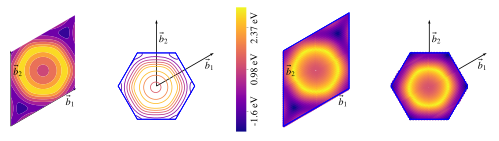

In [ ]:
import matplotlib.pyplot as plt , pivotpy as pp
import matplotlib.tri as tri
axs = pp.get_axes(ncols=5,figsize=(9,2.3),widths=[5,5,0.5,5,5])
evr = pp.Vasprun('../graphene_example/ISPIN_1/dos/vasprun.xml').data

kpoints = np.concatenate([evr.kpoints, -evr.kpoints]) # negative side
bz1 = get_bz(evr.poscar.basis,primitive=True)
bz2 = get_bz(evr.poscar.basis,primitive=False)
out1 = kpoints2bz(bz1,kpoints,primitive=True) + 0.002 #Just fun translate
out2 = kpoints2bz(bz2,kpoints,primitive=False)
splot_bz(bz1,plane='xy',ax = axs[0],color=(1,1,1,0)).set_axis_off()
splot_bz(bz2,plane='xy',ax = axs[1]).set_axis_off()
splot_bz(bz1,plane='xy',ax = axs[3]).set_axis_off()
splot_bz(bz2,plane='xy',ax = axs[4]).set_axis_off()

# Energy as color on BZ. 
en = evr.bands.evals[:,8].ravel()
en = np.concatenate([en,en])
s_en = (en-np.min(en))/(np.max(en)-np.min(en)) # bring to range [0,1] for colors
c = plt.cm.get_cmap('plasma')(s_en)
labels = [str(l) + ' eV' for l in np.round(np.min(en)+(np.max(en)-np.min(en))*np.array([1/6,3/5,5/6]),2)]
tri1 = tri.Triangulation(out1.T[0], out1.T[1])
tri2 = tri.Triangulation(out2.T[0], out2.T[1])
axs[0].tricontourf(tri1, en, levels=np.linspace(-2.6, 3.4, 8), cmap='plasma',shading='nearest')
axs[1].tricontour(tri2, en, levels=np.linspace(-2.6, 3.4, 8), cmap='plasma',linewidths=[0.8])
axs[3].scatter(out1[:,0],out1[:,1],s=4,c=c)
axs[4].scatter(out2[:,0],out2[:,1],s=4,c=c)

axs[2].add_colorbar(cax=axs[2],cmap_or_clist='plasma', ticklabels=labels,vertical=True)


In [ ]:
#export
def fix_sites(poscar,tol=1e-2,eqv_sites=True,translate=None):
    """Add equivalent sites to make a full data shape of lattice. Returns same data after fixing.
    - **Parameters**
        - poscar: Output of `export_poscar` or `export_vasprun().poscar`.
        - tol   : Tolerance value. Default is 0.01.
        - eqv_sites: If True, add sites on edges and faces. If False, just fix coordinates, i.e. `pos > 1 - tol -> pos - 1`, useful for merging poscars to make slabs.
        - translate: A number(+/-) or list of three numbers to translate in x,y,z directions.
    """
    pos = poscar.positions.copy() # Must to avoid chnaging outside.
    labels = poscar.labels
    out_dict = poscar.to_dict() # For output

    if translate and isinstance(translate,(int,float)):
        pos = pos + (translate - int(translate)) # Only translate in 0 - 1 
    elif translate and len(translate) == 3:
        txyz = np.array([translate])
        pos = pos + (txyz - txyz.astype(int))

    if eqv_sites:
        inds, new_pos = [],[]
        for p in product([-1,0,1],[-1,0,1],[-1,0,1]):
            t_pos = pos + [[*p]] # test position.
            t_inds = [i for i,t_p in enumerate(
                (t_pos > -tol) & (t_pos < tol+1)
                ) if not False in t_p]
            new_pos = [*new_pos, *t_pos[t_inds]]
            inds = [*inds,*t_inds]

        new_labs = [labels[i] for i in inds]
        new_pos = np.array(new_pos)

        # order things.
        _ord = np.array([[i,l] for i,l in enumerate(new_labs)])
        _ord = _ord[_ord[:,1].argsort()]

        oinds, olabels = _ord[:,0].T.astype(int), _ord[:,1].T
        new_pos = new_pos[oinds] # Order points too
        new_labs = [new_labs[i] for i in oinds] # Order Labels

        ul, ui = np.unique([ol.split()[0] for ol in olabels],
                    return_counts=True)
        eleminds = np.cumsum([0,*ui]) #Element ranges.
        uelems = {l:range(eleminds[i],eleminds[i+1]) for i,l in enumerate(ul)}
        # Update Things
        out_dict['positions'] = new_pos
        out_dict['labels'] = new_labs
        out_dict['unique'] = uelems
    else:
        xinds,yinds = np.where(pos > 1-tol)
        for i,j in zip(xinds,yinds):
            pos[i,j] = pos[i,j] -1

        # Update Things
        out_dict['positions'] = pos

    return serializer.PoscarData(out_dict)

def get_pairs(basis, positions, r, eps=1e-2):
    """Returns a tuple of Lattice (coords,pairs), so coords[pairs] given nearest site bonds.
    - **Parameters**
        - basis: Real space lattice basis.
        - positions: Array(N,3) of fractional positions of lattice sites. If coordinates positions, provide unity basis.
        - r        : Cartesian distance between the pairs in units of Angstrom e.g. 1.2 -> 1.2E-10.
        - eps      : Tolerance value. Default is 10^-2.
    """
    coords = to_R3(basis,positions)
    tree = KDTree(coords)
    inds = np.array([[*p] for p in tree.query_pairs(r,eps=eps)])
    return serializer.dict2tuple('Lattice',{'coords':coords,'pairs':inds})

def _get_bond_length(poscar,given=None,eps=1e-2):
    "eps is add to calculated bond length in order to fix small differences, paramater `given` in range [0,1] which is scaled to V^(1/3)."
    if given != None:
        return given*poscar.volume**(1/3) + eps
    else:
        _coords = to_R3(poscar.basis,poscar.positions)
        _arr = sorted(np.linalg.norm(_coords[1:] - _coords[0],axis=1)) # Sort in ascending. returns list
        return np.mean(_arr[:2]) + eps if _arr else 1 #Between nearest and second nearest.

## Lattice Plotting

In [ ]:
#export
def iplot_lat(poscar,sizes=10,colors='blue',
              bond_length=None,tol=1e-1,eps=1e-2,eqv_sites=True,
              translate = None,
              line_width=4,edge_color = 'black',
              fill=False,alpha=0.4, ortho3d=True,fig=None):
    """Interactive plot of lattice.
    - **Main Parameters**
        - poscar     : Output of export_poscar or export_vasprun().poscar.
        - sizes      : Size of sites. Either one int/float or list equal to type of ions.
        - colors     : Colors of sites. Either one colors or list equal to type of ions.
        - bond_length: Length of bond in fractional unit [0,1]. It is scaled to V^1/3 and auto calculated if not provides.
    Other parameters just mean what they seem to be.
    """
    poscar = fix_sites(poscar=poscar,tol=tol,eqv_sites=eqv_sites,translate=translate)
    bond_length = _get_bond_length(poscar,given=bond_length,eps=eps)
    coords, pairs = get_pairs(basis=poscar.basis,
                        positions =poscar.positions,
                        r=bond_length,eps=eps)
    if not fig:
        fig = go.Figure()

    uelems = poscar.unique.to_dict()
    if not isinstance(sizes,(list,np.ndarray)):
        sizes = [sizes for elem in uelems.keys()]

    if not isinstance(colors, str):
        colors = np.array(colors)
    else:
        colors = [colors for elem in uelems.keys()]

    h_text = np.array(poscar.labels)

    _colors = []
    for i,vs in enumerate(uelems.values()):
        for v in vs:
            _colors.append(colors[i])
    _colors = np.array(_colors)  # Full List

    if np.any(pairs):
        coords_p = coords[pairs] #paired points
        _colors = _colors[pairs] # Colors at pairs
        coords_n = []
        colors_n = []
        for c_p, _c in zip(coords_p,_colors):
            mid = np.mean(c_p,axis=0)
            arr = np.concatenate([c_p[0],mid,mid,c_p[1]]).reshape((-1,2,3))
            coords_n = [*coords_n,*arr] # Same shape
            colors_n = [*colors_n,*_c] # same shape.

        coords_n = np.array(coords_n)
        colors_n = np.array(colors_n)

        for (i, cp),c in zip(enumerate(coords_n),colors_n):
            showlegend = True if i==0 else False
            fig.add_trace(go.Scatter3d(
                x = cp[:,0].T,
                y = cp[:,1].T,
                z = cp[:,2].T,
                mode='lines',line_color=c,
                legendgroup='Bonds',showlegend=showlegend,
                name='Bonds',line_width=line_width))

    for (k,v),c,s in zip(uelems.items(),colors,sizes):
        fig.add_trace(go.Scatter3d(
            x = coords[v][:,0].T,
            y = coords[v][:,1].T,
            z = coords[v][:,2].T,
            mode='markers',marker_color=c,
            hovertext = h_text[v],
            line_color='rgba(1,1,1,0)',line_width=0.001,
            marker_size = s,opacity=1,name=k))
    bz = get_bz(path_pos=poscar.rec_basis, primitive=True)
    _ = iplot_bz(bz,fig=fig,vname='a',color=edge_color,
                fill=fill,alpha=alpha,ortho3d=ortho3d)
    return fig

In [ ]:
import pivotpy as pp
fig=iplot_lat(evr.poscar,sizes=10,colors=['blue','red','green'],line_width=4,fill=False)
pp.iplot2html(fig,modebar=False)

In [ ]:
#export
def splot_lat(poscar,sizes=50,colors=[],colormap=None,
              bond_length=None,tol=1e-1,eps=1e-2,eqv_sites=True,
              translate = None,
              line_width=1,edge_color=((1,0.5,0,0.4)),
              vectors=True,v3=False,plane=None,
              light_from=(1,1,1),
              fill=False,alpha=0.4,ax=None):
    """Static plot of lattice.
    - **Main Parameters**
        - poscar     : Output of export_poscar or export_vasprun().poscar.
        - sizes      : Size of sites. Either one int/float or list equal to type of ions.
        - bond_length: Length of bond in fractional unit [0,1]. It is scaled to V^1/3 and auto calculated if not provides.
        - colors: List of colos. If given, preffered over colormap, should have same length as type of ions.
    Other parameters just mean what they seem to be.

    > Tip: Use `plt.style.use('ggplot')` for better 3D perception.
    """
    #Plane fix
    if plane and plane not in 'xyzxzyx':
        raise ValueError("plane expects in 'xyzxzyx' or None.")
    if plane:
        ind = 'xyzxzyx'.index(plane)
        arr = [0,1,2,0,2,1,0]
        ix,iy = arr[ind], arr[ind+1]
    poscar = fix_sites(poscar=poscar,tol=tol,eqv_sites=eqv_sites,translate=translate)
    bond_length = _get_bond_length(poscar,given=bond_length,eps=eps)
    coords, pairs = get_pairs(basis=poscar.basis,
                        positions =poscar.positions,
                        r=bond_length,eps=eps)
    bz = get_bz(poscar.rec_basis, primitive=True)
    ax = splot_bz(bz,ax=ax,vname='a',
                color=edge_color,colormap=colormap,
                fill=fill,alpha=alpha,plane=plane,v3=v3,
                vectors=vectors,light_from=light_from)

    uelems = poscar.unique.to_dict()
    if not isinstance(sizes,(list,np.ndarray)):
        sizes = [sizes for elem in uelems.keys()]

    if not colormap in plt.colormaps():
        colormap = 'brg'

    if not colors or len(colors) != len(uelems):
        colors = plt.cm.get_cmap(colormap)(np.linspace(0.1,0.9,len(uelems)))

    _colors = []
    for i,vs in enumerate(uelems.values()):
        for v in vs:
            _colors.append(colors[i])
    _colors = np.array(_colors)  # Full List

    if np.any(pairs):
        coords_p = coords[pairs] #paired points
        _colors = _colors[pairs] # Colors at pairs
        coords_n = []
        colors_n = []
        for c_p, _c in zip(coords_p,_colors):
            mid = np.mean(c_p,axis=0)
            arr = np.concatenate([c_p[0],mid,mid,c_p[1]]).reshape((-1,2,3))
            coords_n = [*coords_n,*arr] # Same shape
            colors_n = [*colors_n,*_c] # same shape.

        coords_n = np.array(coords_n)
        colors_n = np.array(colors_n)

        if not plane:
            _ = [ax.plot(*c.T,c=_c,lw=line_width) for c,_c in zip(coords_n,colors_n)]
        elif plane in 'xyzxzyx':
            _ = [ax.plot(c[:,ix],c[:,iy],c=_c,lw=line_width) for c,_c in zip(coords_n,colors_n)]

    for (k,v),c,s in zip(uelems.items(),colors,sizes):
        if not plane:
            ax.scatter(coords[v][:,0],coords[v][:,1],coords[v][:,2],color = c ,s =s,label=k,depthshade=False)
        elif plane in 'xyzxzyx':
            ax.scatter(coords[v][:,ix],coords[v][:,iy],color = c ,s =s,label=k,zorder=3)
    ax.set_axis_off()
    sp.add_legend(ax)
    return ax

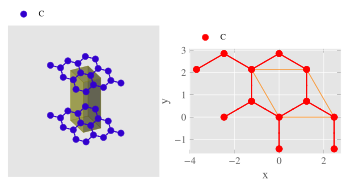

In [ ]:
plt.style.use('ggplot')
axs = pp.get_axes((6,6),ncols=2,axes_3d=[0,])
splot_lat(evr.poscar,sizes=40,plane=None,fill=True,tol=1,alpha=0.4,light_from=(1,-0.1,0),vectors=False,ax=axs[0],edge_color=(0.5,0.5,0,0.4))
splot_lat(evr.poscar,sizes=40,plane='xy',fill=True,tol=1,alpha=0.4,light_from=(1,-0.1,0),vectors=False,ax=axs[1],colors=['red'],translate=[-2/3,-1/3,0]).set_axis_on()
axs[0].view_init(70,75)

## Joining Multiple POSCARS
This is useful to create slabs for interface calculations or even to make supercell in a straightforward way.

In [ ]:
#export
def join_poscars(poscar1,poscar2,direction='z',tol=1e-2):
    """Joins two POSCARs in a given direction. In-plane lattice parameters are kept from `poscar1` and basis of `poscar2` parallel to `direction` is modified while volume is kept same.
    - **Parameters**
        - poscar1, poscar2:  Base and secondary POSCARs respectivly. Output of `export_poscar` or similar object from other functions.
        - direction: The joining direction. It is general and can join in any direction along basis. Expect one of ['a','b','c','x','y','z'].
        - tol: Default is 0.01. It is used to bring sites near 1 to near zero in order to complete sites in plane. Vasp relaxation could move a point, say at 0.00100 to 0.99800 which is not useful while merging sites.
    """
    _poscar1 = fix_sites(poscar1,tol=tol,eqv_sites=False)
    _poscar2 = fix_sites(poscar2,tol=tol,eqv_sites=False)
    pos1 = _poscar1.positions.copy()
    pos2 = _poscar2.positions.copy()

    s1,s2 = 0.5, 0.5 # Half length for each.
    a1,b1,c1 = np.linalg.norm(_poscar1.basis,axis=1)
    a2,b2,c2 = np.linalg.norm(_poscar2.basis,axis=1)
    basis = _poscar1.basis.copy() # Must be copied, otherwise change outside.

    # Processing in orthogonal space
    if direction in ['z','c']:
        c2 = (a2*b2)/(a1*b1)*c2
        netc = c1+c2
        s1, s2 = c1/netc, c2/netc
        pos1[:,2] = s1*pos1[:,2]
        pos2[:,2] = s2*pos2[:,2] + s1
        basis[2] = netc*basis[2]/np.linalg.norm(basis[2]) #Update 3rd vector

    elif direction in ['y','b']:
        b2 = (a2*c2)/(a1*c1)*b2
        netb = b1+b2
        s1, s2 = b1/netb, b2/netb
        pos1[:,1] = s1*pos1[:,1]
        pos2[:,1] = s2*pos2[:,1] + s1
        basis[1] = netb*basis[1]/np.linalg.norm(basis[1]) #Update 2nd vector

    elif direction in ['x','a']:
        a2 = (b2*c2)/(b1*c1)*a2
        neta = a1+a2
        s1, s2 = a1/neta, a2/neta
        pos1[:,0] = s1*pos1[:,0]
        pos2[:,0] = s2*pos2[:,0] + s1
        basis[0] = neta*basis[0]/np.linalg.norm(basis[0]) #Update 1st vector

    else:
        raise Exception("direction expects one of ['a','b','c','x','y','z']")

    rec_basis = np.linalg.inv(basis).T # Transpose is must
    volume = np.dot(basis[0],np.cross(basis[1],basis[2]))
    u1 = _poscar1.unique.to_dict()
    u2 = _poscar2.unique.to_dict()
    u_all = np.unique([*u1.keys(),*u2.keys()])


    pos_all = []
    i_all = []
    for u in u_all:
        _i_ = 0
        if u in u1.keys():
            _i_ = len(u1[u])
            pos_all = [*pos_all,*pos1[u1[u]]]
        if u in u2.keys():
            _i_ = _i_ + len(u2[u])
            pos_all = [*pos_all,*pos2[u2[u]]]
        i_all.append(_i_)

    labels = [f"{u} {i+1}" for u,ii in zip(u_all,i_all) for i in range(ii)]
    i_all = np.cumsum([0,*i_all]) # Do it after labels
    uelems = {_u:range(i_all[i],i_all[i+1]) for i,_u in enumerate(u_all)}
    sys = ''.join(uelems.keys()) + "   # Created by Pivotpy"
    out_dict = {'SYSTEM':sys,'volume':volume,'basis':basis,'rec_basis':rec_basis,'positions':np.array(pos_all),'labels':labels,'unique':uelems}
    return serializer.PoscarData(out_dict)

In [ ]:
write_poscar(evr.poscar)
print("===================================================")
write_poscar(evr.poscar,sd_list=['T T T','F F F'])

C2  # Created by Pivotpy
  2.46803100000000    
    1.0000000000000000    0.0000000000000000    0.0000000000000000
   -0.4999997974093519    0.8660251836382931    0.0000000000000000
    0.0000000000000000    0.0000000000000000    8.1029342824300024
  C
  2
Direct
   0.3333330000000000   0.6666670000000000   0.0000000000000000
   0.6666670000000000   0.3333330000000000   0.0000000000000000
C2  # Created by Pivotpy
  2.46803100000000    
    1.0000000000000000    0.0000000000000000    0.0000000000000000
   -0.4999997974093519    0.8660251836382931    0.0000000000000000
    0.0000000000000000    0.0000000000000000    8.1029342824300024
  C
  2
Selective Dynamics
Direct
   0.3333330000000000   0.6666670000000000   0.0000000000000000   T T T
   0.6666670000000000   0.3333330000000000   0.0000000000000000   F F F


In [ ]:
#export
def scale_poscar(path_poscar,scale=(1,1,1),tol=1e-2):
    """Create larger/smaller cell from a given POSCAR.
    - **Parameters**
        - path_poscar: Path/to/POSCAR or `poscar` data object.
        - scale: Tuple of three values along (a,b,c) vectors. int or float values. If number of sites are not as expected in output, tweak `tol` instead of `scale`. You can put a minus sign with `tol` to get more sites and plus sign to reduce sites.
        - tol: It is used such that site positions are blow `1 - tol`, as 1 belongs to next cell, not previous one.
    > Tip: scale = (2,2,2) enlarges a cell and next operation of (1/2,1/2,1/2) should bring original cell back.
    """
    if isinstance(path_poscar,str):
        poscar = export_poscar(path_poscar)
    else:
        poscar = path_poscar

    ii, jj, kk = np.ceil(scale).astype(int) # Need int for joining.
    _orig_poscar = poscar # Assign base for x
    if ii > 1:
        for i in range(1,ii): # 1 poscar is already there.
            poscar = join_poscars(_orig_poscar,poscar,direction='x',tol=tol)
        _orig_poscar = poscar # Reassign base for y

    if jj > 1:
        for i in range(1,jj):
            poscar = join_poscars(_orig_poscar,poscar,direction='y',tol=tol)
        _orig_poscar = poscar # Reassign base for z

    if kk > 1:
        for i in range(1,kk):
            poscar = join_poscars(_orig_poscar,poscar,direction='z',tol=tol)

    new_poscar = poscar.to_dict() # Update in it

    # Get clip fraction
    fi, fj, fk = scale[0]/ii, scale[1]/jj, scale[2]/kk

    # Clip at end according to scale, change length of basis as fractions.
    pos   = poscar.positions.copy()/np.array([fi,fj,fk]) # rescale for clip
    basis = poscar.basis.copy()
    for i,f in zip(range(3),[fi,fj,fk]):
        basis[i] = f*basis[i] # Basis rescale for clip

    new_poscar['basis']      = basis
    new_poscar['volume']     = np.linalg.det(basis)
    new_poscar['rec_basis']  = np.linalg.inv(basis).T

    uelems = poscar.unique.to_dict()
    # Minus in below for block is because if we have 0-2 then 1 belongs to next cell not original.
    positions,drop = [],0
    for key,value in uelems.items():
        i0 = np.where(pos[value][:,0] <= 1 - tol)
        i1 = np.where(pos[value][:,1] <= 1 - tol)
        i2 = np.where(pos[value][:,2] <= 1 - tol)
        all_i = np.intersect1d(np.intersect1d(i0,i1),i2)
        uelems[key] = range(drop,drop + len(all_i))
        positions = [*positions,*pos[value][all_i]] # Pick positions
        drop = len(all_i) #Update for next element

    labels = ["{} {}".format(k,_v - vs[0] + 1) for k,vs in uelems.items() for _v in vs]
    new_poscar['labels']    = labels
    new_poscar['unique']    = uelems
    new_poscar['positions'] = np.array(positions)
    return serializer.PoscarData(new_poscar)

def rotate_poscar(path_poscar,angle_deg,axis_vec):
    """Rotate a given POSCAR.
    - **Parameters**
        - path_poscar: Path/to/POSCAR or `poscar` data object.
        - angle_deg: Rotation angle in degrees. 
        - axis_vec : (x,y,z) of axis about which rotation takes place. Axis passes through origin. 
    """
    if isinstance(path_poscar,str):
        poscar = export_poscar(path_poscar)
    else:
        poscar = path_poscar
    rot = rotation(angle_deg=angle_deg,axis_vec=axis_vec)
    p_dict = poscar.to_dict()
    p_dict['basis'] = rot.apply(p_dict['basis']) # Rotate basis so that they are transpose
    p_dict['rec_basis'] = np.linalg.inv(p_dict['basis']).T # invert rotated basis
    return serializer.PoscarData(p_dict)

<AxesSubplot:xlabel='x', ylabel='y'>

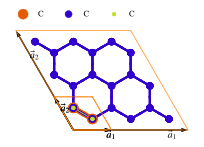

In [ ]:
import numpy as np
import pivotpy.vr_parser as vp
pscr = export_poscar('POSCAR')
ax = splot_lat(pscr,plane='xy',colormap='RGB',sizes=100,line_width=5)
scaled = scale_poscar(pscr, scale=[3,3,3])
splot_lat(scaled, ax=ax,plane='xy',bond_length=0.1,tol=1e-5,line_width=2)
new_scaled = scale_poscar(scaled, scale=[1/3,1/3,1/3],tol=1e-3)
splot_lat(new_scaled,ax=ax,plane='xy',colormap='viridis_r',sizes=15,line_width=0.5)

In [ ]:
#hide_input
from pivotpy.utils import nav_links 
nav_links(5)

<style>a{text-decoration: none !important;color:lightkblue;font-weight:bold;}
                a:focus,a:active,a:hover{color:hotpink !important;}</style>
> [&nbsp;`▶` Index&nbsp;](https://massgh.github.io/pivotpy/)  
> [&nbsp;`▶` XmlElementTree&nbsp;](https://massgh.github.io/pivotpy/XmlElementTree)  
> [&nbsp;`▶` StaticPlots&nbsp;](https://massgh.github.io/pivotpy/StaticPlots)  
> [&nbsp;`▶` InteractivePlots&nbsp;](https://massgh.github.io/pivotpy/InteractivePlots)  
> [&nbsp;`▶` Utilities&nbsp;](https://massgh.github.io/pivotpy/Utilities)  
> [&nbsp;`▶` StructureIO●&nbsp;](https://massgh.github.io/pivotpy/StructureIO)  
> [&nbsp;`▶` Widgets&nbsp;](https://massgh.github.io/pivotpy/Widgets)  
> [&nbsp;`▶` MainAPI&nbsp;](https://massgh.github.io/pivotpy/MainAPI)  
